Part1

In [3]:
import sympy as sp

# 定義符號
alpha, A, B = sp.symbols('alpha A B')

# Bessel 函數 J8 和 Y8
J8 = sp.besselj(8, alpha * 1)
Y8 = sp.bessely(8, alpha * 1)
J16 = sp.besselj(8, alpha * 2)
Y16 = sp.bessely(8, alpha * 2)

# 邊界條件方程式
eq1 = A * J8 + B * Y8      # u(1) = 0
eq2 = A * J16 + B * Y16    # u(2) = 0

# 解 A, B
sol = sp.solve([eq1, eq2], [A, B], dict=True)

# 比例 B/A （從第一個方程）
ratio_B_over_A = sp.simplify(-J8 / Y8)

# 顯示結果
print("對 (A, B) 的一般解：", sol)
print("非零解存在時，B/A =\n", ratio_B_over_A)


對 (A, B) 的一般解： [{A: 0, B: 0}]
非零解存在時，B/A =
 -besselj(8, alpha)/bessely(8, alpha)


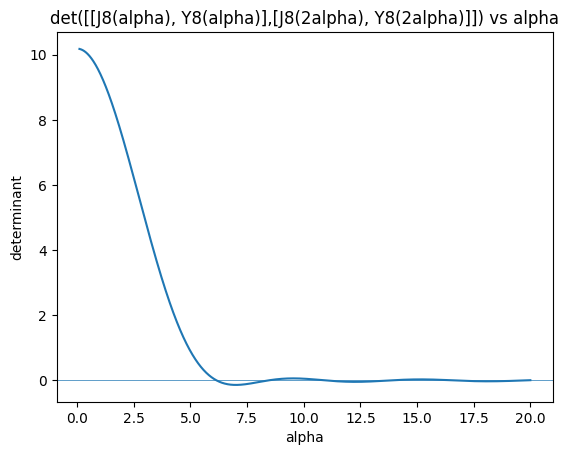

最小正根 alpha ≈ 6.155654


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv, yv, jvp, yvp

# 定義 determinant 函數
def det_func(alpha):
    return jv(8, alpha) * yv(8, 2*alpha) - yv(8, alpha) * jv(8, 2*alpha)

# 定義其導數（解析形式）
def det_prime(alpha):
    dJ8 = jvp(8, alpha)
    dY8 = yvp(8, alpha)
    dJ82 = jvp(8, 2*alpha) * 2
    dY82 = yvp(8, 2*alpha) * 2
    return dJ8 * yv(8, 2*alpha) + jv(8, alpha) * dY82 - (dY8 * jv(8, 2*alpha) + yv(8, alpha) * dJ82)

# 繪製 det(alpha) 圖形
alpha_vals = np.linspace(0.1, 20, 2000)
det_vals = det_func(alpha_vals)

plt.plot(alpha_vals, det_vals)
plt.axhline(0, linestyle='-', linewidth=0.5)
plt.xlabel('alpha')
plt.ylabel('determinant')
plt.title('det([[J8(alpha), Y8(alpha)],[J8(2alpha), Y8(2alpha)]]) vs alpha')
plt.show()

# 找到第一個符號變化點作為 bracket
sign_changes = np.where(np.sign(det_vals[:-1]) != np.sign(det_vals[1:]))[0]
a0, a1 = alpha_vals[sign_changes[0]], alpha_vals[sign_changes[0] + 1]
# 牛頓法初值取 bracket 中點
alpha0 = (a0 + a1) / 2

# Newton 方法尋根
alpha = alpha0
for _ in range(20):
    alpha = alpha - det_func(alpha) / det_prime(alpha)

root = alpha
print(f"最小正根 alpha ≈ {root:.6f}")


In [5]:
# ---- 1. 用高精度 (mpmath) 重新求 α 到 18 位 -------------------
from mpmath import mp, besselj, bessely         
mp.dps = 50                                      

def f_det(a):
    return ( besselj(8, a) * bessely(8, 2*a)
           - bessely(8, a) * besselj(8, 2*a) )

# 利用公式 (18) → d/dx Jn, Yn
def f_prime(a):
    J8, Y8 = besselj(8, a), bessely(8, a)
    J8_2, Y8_2 = besselj(8, 2*a), bessely(8, 2*a)

    J7,  J9  = besselj(7,  a), besselj(9,  a)
    Y7,  Y9  = bessely(7,  a), bessely(9,  a)
    J7_2, J9_2 = besselj(7, 2*a), besselj(9, 2*a)
    Y7_2, Y9_2 = bessely(7, 2*a), bessely(9, 2*a)

    dJ8  = 0.5*(J7  - J9 )
    dY8  = 0.5*(Y7  - Y9 )
    dJ8_2 = 0.5*(J7_2 - J9_2) * 2      
    dY8_2 = 0.5*(Y7_2 - Y9_2) * 2

    return dJ8*Y8_2 + J8*dY8_2 - (dY8*J8_2 + Y8*dJ8_2)

# Newton – 以先前 6 位近似當初值
a = mp.mpf(root)          # root 來自你前一段程式 ≈ 6.155654
for _ in range(40):       
    da = -f_det(a)/f_prime(a)
    a += da
    if mp.fabs(da) < mp.mpf('1e-40'):
        break

alpha_mp = +a             
alpha    = float(a)       
print(f"\nα (18 d.p.) = {mp.nstr(alpha_mp, 20)}")


α (18 d.p.) = 6.1556542986056667536


Max |U0| at r=1: 0.00e+00, r=2: 8.33e-17


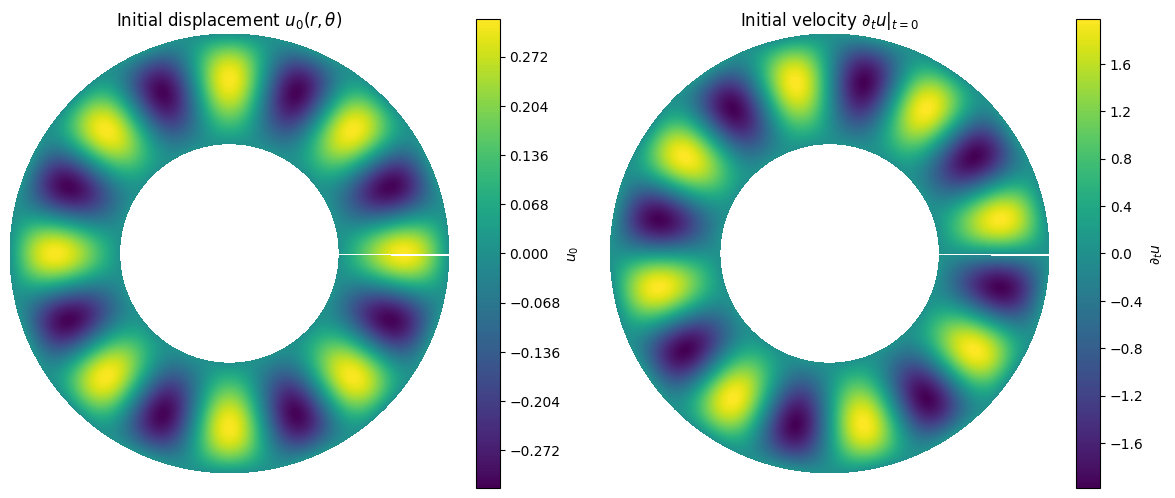

In [6]:
import numpy as np


# 參數設定
alpha = root  # 第一個本徵值
A = 1.0
B = -jv(8, alpha) / yv(8, alpha)  # B/A 比例
omega = alpha  # 假設 c = 1

# 網格依據題目 (6)-(7)
K = 200  # 徑向區間切成 K 段
N = 400  # 角向切成 N+1 點
r = np.linspace(1, 2, K+1)  # r_k = 1 + k/K
theta = np.linspace(0, 2 * np.pi, N+1, endpoint=False)  # θ_n = 2π n/(N+1) ≈ θ_n = n * Δθ

# 極座標網格
R, Theta = np.meshgrid(r, theta)

#  û(r)
Uhat = A * jv(8, alpha * R) + B * yv(8, alpha * R)

# 初始位移場與初始速度場
U0 = Uhat * np.cos(8 * Theta)
U1 = omega * Uhat * np.sin(8 * Theta)

# 檢查邊界 r=1,2 是否為零
max_U0_r1 = np.max(np.abs(U0[:, 0]))
max_U0_r2 = np.max(np.abs(U0[:, -1]))
print(f"Max |U0| at r=1: {max_U0_r1:.2e}, r=2: {max_U0_r2:.2e}")

# 坐標轉換到平面 (x, y)
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

# 使用 contourf 繪圖
fig, axes = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'aspect': 'equal'})


cf0 = axes[0].contourf(X, Y, U0, levels=200)
axes[0].set_title("Initial displacement $u_0(r,\\theta)$")
axes[0].axis('off')
fig.colorbar(cf0, ax=axes[0], label='$u_0$')


cf1 = axes[1].contourf(X, Y, U1, levels=200)
axes[1].set_title("Initial velocity $\\partial_t u |_{t=0}$")
axes[1].axis('off')
fig.colorbar(cf1, ax=axes[1], label='$\\partial_t u$')

plt.tight_layout()
plt.show()


Part2

In [7]:
# ---- 1. 用高精度 (mpmath) 重新求 α 到 18 位 -------------------
from mpmath import mp, besselj, bessely         
mp.dps = 50                                      

def f_det(a):
    return ( besselj(8, a) * bessely(8, 2*a)
           - bessely(8, a) * besselj(8, 2*a) )

# 利用公式 (18) → d/dx Jn, Yn
def f_prime(a):
    J8, Y8 = besselj(8, a), bessely(8, a)
    J8_2, Y8_2 = besselj(8, 2*a), bessely(8, 2*a)

    J7,  J9  = besselj(7,  a), besselj(9,  a)
    Y7,  Y9  = bessely(7,  a), bessely(9,  a)
    J7_2, J9_2 = besselj(7, 2*a), besselj(9, 2*a)
    Y7_2, Y9_2 = bessely(7, 2*a), bessely(9, 2*a)

    dJ8  = 0.5*(J7  - J9 )
    dY8  = 0.5*(Y7  - Y9 )
    dJ8_2 = 0.5*(J7_2 - J9_2) * 2      
    dY8_2 = 0.5*(Y7_2 - Y9_2) * 2

    return dJ8*Y8_2 + J8*dY8_2 - (dY8*J8_2 + Y8*dJ8_2)

# Newton – 以先前 6 位近似當初值
a = mp.mpf(root)          # root 來自你前一段程式 ≈ 6.155654
for _ in range(40):       
    da = -f_det(a)/f_prime(a)
    a += da
    if mp.fabs(da) < mp.mpf('1e-40'):
        break

alpha_mp = +a             
alpha    = float(a)       
print(f"\nα (18 d.p.) = {mp.nstr(alpha_mp, 20)}")

# ---- 2. 初始場 (K,N) = (20,64) --------------------------------
K, N = 20, 64
r  = np.linspace(1.0, 2.0, K+1)                
theta = np.linspace(0.0, 2*np.pi, N+1, endpoint=False)  
R, Theta = np.meshgrid(r, theta)               

A = 1.0
B = -jv(8, alpha*r[0]) / yv(8, alpha*r[0])      
Uhat = A*jv(8, alpha*R) + B*yv(8, alpha*R)

omega = alpha                                   
U0  = Uhat * np.cos(8*Theta)                    
U0p = omega*Uhat * np.sin(8*Theta)              

# ---- 3. LSRK-45 係數 & 右端 -----------------------------------
# ------------------------------------------------------------
# LSRK-45  for  second-order system  (V, Vp)
# ------------------------------------------------------------
A45 = np.array([0.0,
   -567301805773/1357537059087,
   -2404267990393/2016746695238,
   -3550918686646/2091501179385,
   -1275806237668/842570457699], float)

B45 = np.array([
   1432997174477/9575080441755,
   5161836677717/13612068292357,
   1720146321549/2090206949498,
   3134564353537/4481467310338,
   2277821191437/14882151754819], float)

c45 = np.array([
    0.0,
    1432997174477.0 / 9575080441755.0,
    2526269341429.0 / 6820363962896.0,
    2006345519317.0 / 3224310063776.0,
    2802321613138.0 / 2924317926251.0
])

def lsrk45_step(V, Vp, rV, rVp, dt):
    """單一步驟；回傳更新後的 (V, Vp, rV, rVp)"""
    for a, b in zip(A45, B45):
        #  右端
        rhs_V   = Vp
        rhs_Vp  = -alpha**2 * V
        # 暫存
        rV  = a*rV  + dt*rhs_V
        rVp = a*rVp + dt*rhs_Vp
        # 主變數
        V  += b*rV
        Vp += b*rVp
    return V, Vp, rV, rVp


# ---- 4. 時間收斂測試 ------------------------------------------
def run_sim(CFL):
    dt  = CFL * min(2*np.pi/(N+1), 1/K)
    T   = 2*np.pi/alpha
    n   = int(np.ceil(T/dt))
    dt  = T / n          
    V, Vp  = U0.copy(), U0p.copy()
    rV     = np.zeros_like(V)
    rVp    = np.zeros_like(V)
    for _ in range(n):
        V, Vp, rV, rVp = lsrk45_step(V, Vp, rV, rVp, dt)
    V_exact = Uhat * np.cos(8*Theta - omega*T)
    return np.max(np.abs(V - V_exact))


CFLs  = [1.0, 0.5, 0.25, 0.125, 0.0625]
errs  = [run_sim(c) for c in CFLs]

print("\n----  Part II  Convergence (LSRK-45) ----")
print("CFL      e_inf           C.R.")
for j, (cfl, err) in enumerate(zip(CFLs, errs)):
    if j == 0:
        print(f"{cfl:4.3f}  {err:12.5e}   -")
    else:
        rate = np.log(errs[j-1]/err)/np.log(2)
        print(f"{cfl:4.3f}  {err:12.5e}  {rate:5.2f}")



α (18 d.p.) = 6.1556542986056667536

----  Part II  Convergence (LSRK-45) ----
CFL      e_inf           C.R.
1.000   5.38953e-05   -
0.500   3.70224e-06   3.86
0.250   2.31263e-07   4.00
0.125   1.44553e-08   4.00
0.062   9.14453e-10   3.98


Part3

In [8]:
import numpy as np
from scipy.special import jv, yv

# alpha 及對應係數
alpha = 6.155654298605667  # 根據 Part I/II 求得，本例取 α ≈ 6.1556543
omega = alpha             # 波速 c=1，故 ω = α
A = 1.0
B = - jv(8, alpha) / yv(8, alpha)  # 比例係數 B/A:contentReference[oaicite:2]{index=2}

# 固定徑向網格劃分 K=20，生成徑向座標 (包含邊界 r=1,2)
K = 20
r = np.linspace(1.0, 2.0, K+1)   # r_k = 1 + k*(1/20), k=0..20
# 定義解析解的徑向函數 \hat{u}(r) = A J_8(αr) + B Y_8(αr)
Uhat = A * jv(8, alpha * r) + B * yv(8, alpha * r)
# 邊界處理：理論上 \hat{u}(1)=\hat{u}(2)=0，數值上設為0確保邊界為零
Uhat[0] = 0.0
Uhat[-1] = 0.0

# 初始角度分佈 (此處先不決定角向點數 N，在主程式中設定)
# 範例：假設 N=64（角向點數），則 theta 間隔 Δθ = 2π/N
N = 64
theta = np.linspace(0.0, 2*np.pi, N, endpoint=False)
# 計算初始位移 U0 和初始速度 U0p (維度: N × (K+1))
U0 = np.outer(np.cos(8*theta), Uhat)
U0p = omega * np.outer(np.sin(8*theta), Uhat)
# 確認邊界 r=1,2 的初始值為零
U0[:, 0] = 0.0; U0[:, -1] = 0.0
U0p[:, 0] = 0.0; U0p[:, -1] = 0.0
print(f"Max |U0| at r=1: {np.max(np.abs(U0[:,0])):.2e}, r=2: {np.max(np.abs(U0[:,-1])):.2e}")


Max |U0| at r=1: 0.00e+00, r=2: 0.00e+00


In [9]:
def fourier_theta_dd(V):
    N = V.shape[0]  # 角向網格點數
    # 對每個徑向列對θ做 FFT
    F = np.fft.fft(V, axis=0)
    # 構造頻率波數序列 k (對應模式 0,1,...,N-1，其中 N/2..N-1 對應負頻率) 
    k = (np.fft.fftfreq(N, 1.0) * N).astype(int)
    # 頻譜中乘以 -(k^2)
    F *= -(k**2)[:, None]
    # 反傅里葉變換回實空間，取實部作為θ二階導數
    return np.fft.ifft(F, axis=0).real


In [10]:



def lsrk45_step(V, Vp, t0, dt):
    """
    V, Vp: 當前場與場導
    t0:    當前時間
    dt:    時間步長
    回傳更新後的 V, Vp, t0+dt
    """
    rV  = np.zeros_like(V)
    rVp = np.zeros_like(Vp)

    for a, b, ci in zip(A45, B45, c45):
        t_stage = t0 + ci * dt
        # 即便 RHS 不依賴 t_stage，這裡示範如何傳入
        # 先前定義的徑向解析算子 + 角向 Fourier
        Fr     = -alpha**2 * V + (64.0/r**2)[None,:] * V
        Fth    = (1.0/r**2)[None,:] * fourier_theta_dd(V)
        rhs_V  = Vp
        rhs_Vp = Fr + Fth

        # LSRK 低儲存公式更新
        rV   = a * rV   + dt * rhs_V
        rVp  = a * rVp  + dt * rhs_Vp
        V    = V    + b * rV
        Vp   = Vp   + b * rVp

        # Dirichlet 邊界
        V [:, 0] = V [:,-1] = 0.0
        Vp[:, 0] = Vp[:,-1] = 0.0

    return V, Vp, t0 + dt


In [11]:
import pandas as pd

# 定義模擬函式：給定角向分割數 N，回傳誤差無窮範數
def run_simulation(N, CFL=0.5):
    theta = np.linspace(0.0, 2*np.pi, N, endpoint=False)
    V  = np.outer(np.cos(8*theta), Uhat)
    Vp = omega * np.outer(np.sin(8*theta), Uhat)
    V[:, 0] = V[:, -1] = 0.0
    Vp[:,0] = Vp[:, -1] = 0.0

    dt = CFL * min(2*np.pi/N, 1.0/K)
    T  = 2*np.pi/alpha
    n_steps = int(np.ceil(T/dt))
    dt = T / n_steps

    t = 0.0
    for _ in range(n_steps):
        V, Vp, t = lsrk45_step(V, Vp, t, dt)

    V_exact = np.outer(np.cos(8*theta - omega*T), Uhat)
    return np.max(np.abs(V - V_exact))

# 執行不同 N 下的模擬並收集誤差
Ns   = [64, 96, 128, 192, 288, 432, 648]
errs = [run_simulation(N) for N in Ns]
# 計算相鄰收斂率
CR = ["-"]
for j in range(1, len(errs)):
    rate = np.log(errs[j-1] / errs[j]) / np.log(Ns[j] / Ns[j-1])
    CR.append(f"{rate:.2f}")
# 以 Pandas DataFrame 顯示結果
df = pd.DataFrame({
    'N':    Ns,
    'e_inf': errs,
    'C.R.': CR
})
# 用 to_string 輸出，index=False 去掉左邊索引欄
print(df.to_string(index=False, float_format='%.5e'))

  N       e_inf C.R.
 64 3.68798e-06    -
 96 3.68798e-06 0.00
128 3.34962e-06 0.33
192 6.62834e-07 4.00
288 1.33843e-07 3.95
432 2.64427e-08 4.00
648 5.27551e-09 3.98


完整程式碼(Part4)

In [12]:
import numpy as np
from scipy.special import jv, yv

#  alpha 及對應係數
alpha = 6.155654298605667  # 根據 Part I/II 求得，本例取 α ≈ 6.1556543
omega = alpha             # 波速 c=1，故 ω = α
A = 1.0
B = - jv(8, alpha) / yv(8, alpha)  # 比例係數 B/A

# 固定徑向網格劃分 K=20，生成徑向座標 (包含邊界 r=1,2)
K = 20
r = np.linspace(1.0, 2.0, K+1)   # r_k = 1 + k*(1/20), k=0..20
# 定義解析解的徑向函數 \hat{u}(r) = A J_8(αr) + B Y_8(αr)
Uhat = A * jv(8, alpha * r) + B * yv(8, alpha * r)
# 邊界處理：理論上 \hat{u}(1)=\hat{u}(2)=0，數值上設為0確保邊界為零
Uhat[0] = 0.0
Uhat[-1] = 0.0

# 初始角度分佈 (此處先不決定角向點數 N，在主程式中設定)
# 範例：假設 N=64（角向點數），則 theta 間隔 Δθ = 2π/N
N = 64
theta = np.linspace(0.0, 2*np.pi, N, endpoint=False)
# 計算初始位移 U0 和初始速度 U0p (維度: N × (K+1))
U0 = np.outer(np.cos(8*theta), Uhat)
U0p = omega * np.outer(np.sin(8*theta), Uhat)
# 確認邊界 r=1,2 的初始值為零
U0[:, 0] = 0.0; U0[:, -1] = 0.0
U0p[:, 0] = 0.0; U0p[:, -1] = 0.0
print(f"Max |U0| at r=1: {np.max(np.abs(U0[:,0])):.2e}, r=2: {np.max(np.abs(U0[:,-1])):.2e}")


Max |U0| at r=1: 0.00e+00, r=2: 0.00e+00


In [13]:
def fourier_theta_dd(V):
    N = V.shape[0]  # 角向網格點數
    # 對每個徑向列對θ做 FFT
    F = np.fft.fft(V, axis=0)
    # 構造頻率波數序列 k (對應模式 0,1,...,N-1，其中 N/2..N-1 對應負頻率) 
    k = (np.fft.fftfreq(N, 1.0) * N).astype(int)
    # 頻譜中乘以 -(k^2)
    F *= -(k**2)[:, None]
    # 反傅里葉變換回實空間，取實部作為θ二階導數
    return np.fft.ifft(F, axis=0).real


In [14]:
def radial_fd(V, r):
    N, K1 = V.shape
    dr = r[1] - r[0]
    dV = np.zeros_like(V)
    # rur at midpoints
    rur_mid = ((r[:-1] + r[1:]) / 2)[None, :] * (V[:, 1:] - V[:, :-1]) / dr
    # 二階差分
    dV[:, 1:-1] = (rur_mid[:, 1:] - rur_mid[:, :-1]) / (r[1:-1][None, :] * dr)
    dV[:, 0] = 0.0
    dV[:, -1] = 0.0
    return dV



In [15]:
def F_rhs(V, r):
    """
    計算右端 F(V): 包含 r 向有限差分、θ 向 Fourier
    """
    # 徑向二階有限差分
    F_r = radial_fd(V, r)
    # θ 方向 Fourier 二階微分
    F_theta = fourier_theta_dd(V)
    # 合併右端
    return F_r + (1.0 / (r**2))[None, :] * F_theta


In [16]:
def lsrk45_step(V, Vp, dt, r):
    rV = np.zeros_like(V)
    rVp = np.zeros_like(V)
    for a, b in zip(A45, B45):
        rhs_V  = Vp
        rhs_Vp = F_rhs(V, r)
        # 累積更新
        rV  = a * rV  + dt * rhs_V
        rVp = a * rVp + dt * rhs_Vp
        V   = V   + b * rV
        Vp  = Vp  + b * rVp
        # 強制邊界
        V[:, 0] = 0.0; V[:, -1] = 0.0
        Vp[:, 0] = 0.0; Vp[:, -1] = 0.0
    return V, Vp


In [17]:
A45 = np.array([0.0,
   -567301805773/1357537059087,
   -2404267990393/2016746695238,
   -3550918686646/2091501179385,
   -1275806237668/842570457699], float)

B45 = np.array([
   1432997174477/9575080441755,
   5161836677717/13612068292357,
   1720146321549/2090206949498,
   3134564353537/4481467310338,
   2277821191437/14882151754819], float)

In [37]:
import pandas as pd

# 定義模擬函式：給定角向分割數 N，回傳誤差無窮範數
def run_simulation(N, K=None, CFL=1):
    if K is None:
        K = N
    r = np.linspace(1.0, 2.0, K+1)
    Uhat = A * jv(8, alpha * r) + B * yv(8, alpha * r)
    Uhat[0] = 0.0; Uhat[-1] = 0.0
    theta = np.linspace(0.0, 2*np.pi, N, endpoint=False)
    V  = np.outer(np.cos(8*theta), Uhat)
    Vp = omega * np.outer(np.sin(8*theta), Uhat)
    V[:, 0] = 0.0; V[:, -1] = 0.0
    Vp[:, 0] = 0.0; Vp[:, -1] = 0.0
    dt = CFL * min(2*np.pi/N, 1.0/K)
    T = 2 * np.pi / alpha
    n_steps = int(np.ceil(T / dt))
    dt = T / n_steps
    for _ in range(n_steps):
        V, Vp = lsrk45_step(V, Vp, dt, r)
    V_exact = np.outer(np.cos(8*theta - omega*T), Uhat)
    error = np.max(np.abs(V - V_exact))
    return error


# 執行不同 N 下的模擬並收集誤差
Ns = [192, 192, 192, 192, 192, 192, 192,192,192]
Ks = [32, 48, 64, 96, 128, 192, 256,160,224]
errs = [run_simulation(N, K) for N, K in zip(Ns, Ks)]

# 計算相鄰收斂率
CR = ["-"]
for j in range(1, len(errs)):
    rate = np.log(errs[j-1] / errs[j]) / np.log(Ks[j] / Ks[j-1])
    CR.append(f"{rate:.2f}")
# 以 Pandas DataFrame 顯示結果
df = pd.DataFrame({
    'KS':    Ks,
    'e_inf': errs,
    'C.R.': CR
})
# 用 to_string 輸出，index=False 去掉左邊索引欄
print(df.to_string(index=False, float_format='%.5e'))

 KS       e_inf C.R.
 32 5.26419e-04    -
 48 2.32911e-04 2.01
 64 1.30687e-04 2.01
 96 5.79995e-05 2.00
128 3.26050e-05 2.00
192 1.44853e-05 2.00
256 8.14749e-06 2.00
160 2.08617e-05 2.00
224 1.06419e-05 2.00


繪製動畫

In [19]:
import matplotlib.animation as animation
print(animation.writers.list())   # 應該看得到 'ffmpeg'


['pillow', 'html']


In [27]:
import numpy as np, matplotlib.pyplot as plt
from matplotlib import cm, animation
from pathlib import Path




def simulate_and_make_movie(N=64, K=20, CFL=0.5,
                            periods=8, frames_target=240,
                            outfile='wave_ring_8periods.mp4'):

    r = np.linspace(1.0, 2.0, K+1)
    theta = np.linspace(0.0, 2*np.pi, N, endpoint=False)
    V  = np.outer(np.cos(8*theta), Uhat)
    Vp = omega * np.outer(np.sin(8*theta), Uhat)
    V[:, 0] = V[:, -1] = 0.0
    Vp[:, 0] = Vp[:, -1] = 0.0

    dt = CFL * min(2*np.pi/N, 1.0/K)
    T_period = 2*np.pi/alpha
    T_total  = periods*T_period
    n_steps  = int(np.ceil(T_total/dt))
    dt       = T_total/n_steps
    save_every = max(1, n_steps // frames_target)

    R, Theta = np.meshgrid(r, theta)
    X = R*np.cos(Theta); Y = R*np.sin(Theta)

    snapshots, times = [], []
    for step in range(n_steps+1):
        if step % save_every == 0:
            snapshots.append(V.copy())
            times.append(step*dt)
        if step == n_steps:
            break
        V, Vp = lsrk45_step(V, Vp, dt, r)

    snapshots = np.asarray(snapshots)
    zlim = float(np.max(np.abs(snapshots)))*1.05

    fig = plt.figure(figsize=(8,6))
    ax  = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('u')
    ax.set_zlim(-zlim, zlim)

    # 先畫第一張
    surf = ax.plot_surface(X, Y, snapshots[0],
                           cmap=cm.viridis,
                           linewidth=0, antialiased=False)

    def update(frame):
        while ax.collections:          # 刪掉舊 surface
            ax.collections[0].remove()
        ax.plot_surface(X, Y, snapshots[frame],
                        cmap=cm.viridis,
                        linewidth=0, antialiased=False)
        ax.set_title(f't = {times[frame]:.3f}')
        return ax.collections    # 傳回 artist 列表

    ani = animation.FuncAnimation(fig, update,
                                  frames=len(snapshots),
                                  interval=33, blit=False)

    # ---- 選擇 writer：優先 ffmpeg，其次 pillow ---- #
    if 'ffmpeg' in animation.writers.list():
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=30, bitrate=2000)
    else:
        from matplotlib.animation import PillowWriter
        writer = PillowWriter(fps=15)
        outfile = Path(outfile).with_suffix('.gif')

    ani.save(outfile, writer=writer)
    plt.close(fig)
    print(f'✅ 動畫已輸出：{Path(outfile).resolve()}')

# ------------ 執行 ------------- #
simulate_and_make_movie()


✅ 動畫已輸出：C:\Users\Funtrollor\Desktop\科學計算導論\wave_ring_8periods.gif
